In [2]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt

import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt

def flatten_metrics(metrics):
    flattened = {}
    flattened["CoLA"] = {
        "metric": "mcc",
        "mean": metrics['CoLA']['mcc'][0],
        "stdv": metrics['CoLA']['mcc'][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    
    flattened["MNLI"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli_acc"][0],
        "stdv": metrics["MNLI"]["mnli_acc"][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    flattened["MRPC"] = {
        "metric": "acc",
        "mean": metrics["MRPC"]["acc"][0],
        "stdv": metrics["MRPC"]["acc"][1]
    }
    flattened["QNLI"] = {
        "metric": "acc",
        "mean": metrics["QNLI"]["acc"][0],
        "stdv": metrics["QNLI"]["acc"][1]
    }
    flattened["QQP"] = {
        "metric": "acc",
        "mean": metrics["QQP"]["acc"][0],
        "stdv": metrics["QQP"]["acc"][1]
    }
    flattened["RTE"] = {
        "metric": "acc",
        "mean": metrics["RTE"]["acc"][0],
        "stdv": metrics["RTE"]["acc"][1]
    }
    flattened["SST-2"] = {
        "metric": "acc",
        "mean": metrics["SST-2"]["acc"][0],
        "stdv": metrics["SST-2"]["acc"][1]
    }
    flattened["STS-B"] = {
        "metric": "corr",
        "mean": metrics["STS-B"]["pearson"][0],
        "stdv": metrics["STS-B"]["pearson"][1]
    }
    flattened["WNLI"] = {
        "metric": "acc",
        "mean": metrics["WNLI"]["acc"][0],
        "stdv": metrics["WNLI"]["acc"][1]
    }
    return flattened

def plot_task_metrics(experiment_metrics, task, title):
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in experiment_metrics]
    
    experiment_names = [e_m[0] for e_m in experiment_metrics]
    metrics_data = [e_m[1] for e_m in experiment_metrics]
    
    x_pos = np.arange(len(experiment_names))
    means = [m[task]["mean"] for m in metrics_data]
    errors = [m[task]["stdv"] for m in metrics_data]
    fig, ax = plt.subplots(figsize=(9,9))
    ax.bar(x_pos, means, yerr=errors, align='center', color="#ea593f")
    ax.set_ylabel(metrics_data[0][task]["metric"])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(experiment_names, rotation='vertical')
    ax.set_title(f"{title} : {task}")
    ax.yaxis.grid(True)
    #plt.tight_layout()
    plt.show()

def plot_all_task_metrics(metrics, title):
    for name in metrics[0][1].keys():
        plot_task_metrics(analyzed_metrics, name, title)


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title=''):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=plt.cm.OrRd)

    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path)



In [1]:
def load_head_data(experiments_path):
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            #head_importance = np.load(seed_dir / "head_importance.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
                #"head_importance": head_importance
            }
    return head_data
def load_mlp_data(experiments_path):
    mlp_data = {}
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "mlp_importance": mlp_importance
            }
    return mlp_data


In [3]:

experiments_path = pathlib.Path("../masks_results")
head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../mlp_masks_results")
mlp_data = load_mlp_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_mlp_data = load_mlp_data(experiments_path)

# Task wise overlap % of pruned masks for each seed

In [4]:
def task_overlap_attention_heads(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_heads = np.sum(head_data[task_1][seed]["head_mask"] * head_data[task_2][seed]["head_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_heads
                
    mean_shared_heads = np.mean(results, axis=0)
    std_shared_heads = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_heads, std_shared_heads, tasks, tasks, save_name, "Task", "Task")

def task_overlap_mlps(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_mlps = np.sum(mlp_data[task_1][seed]["mlp_mask"] * mlp_data[task_2][seed]["mlp_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_mlps
                
    mean_shared_mlps = np.mean(results, axis=0)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_mlps, std_shared_mlps, tasks, tasks, save_name, "Task", "Task")

## Task vs Task shared heads - Heads found separately

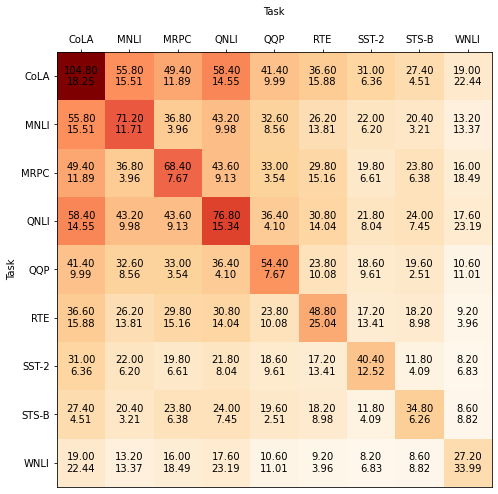

In [5]:
task_overlap_attention_heads(head_data, "task_v_task_heads_separate.pdf")

## Task vs Task shared heads - Heads found together with MLPs setting

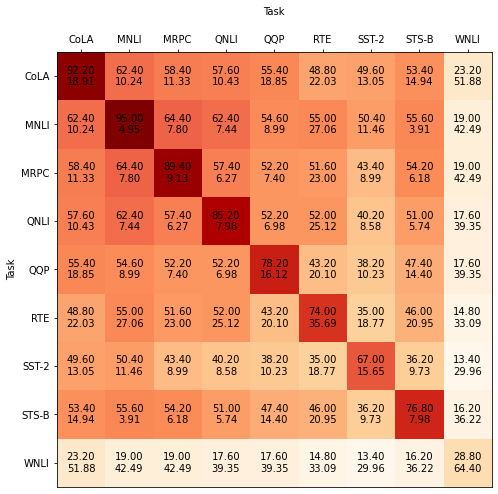

In [6]:

task_overlap_attention_heads(n_head_data, "task_v_task_heads_together.pdf")

## Task vs Task shared MLPs - MLPS found separate

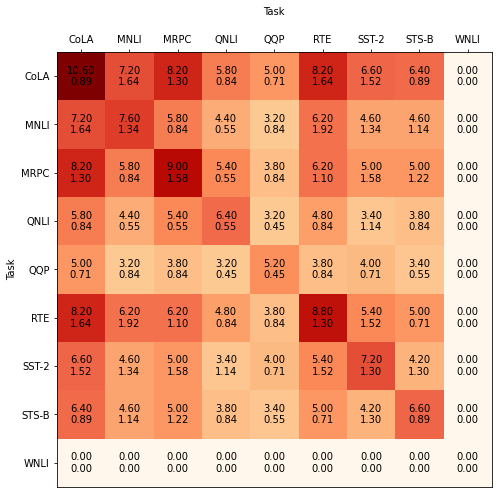

In [131]:

task_overlap_mlps(mlp_data, "task_v_task_mlps_separate.pdf")

## Task vs Task shared MLPs - MLPS found together with Heads

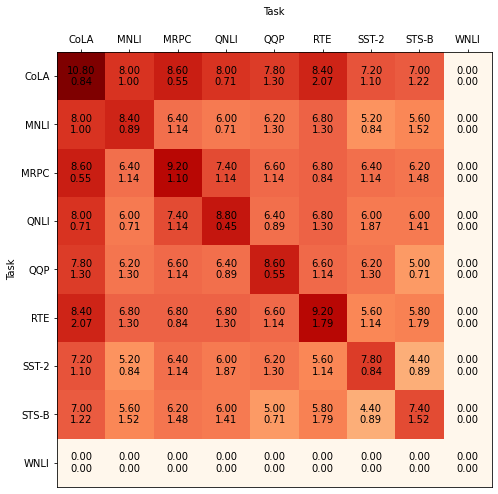

In [7]:

task_overlap_mlps(n_mlp_data, "task_v_task_mlps_together.pdf")

# Components heatmap

In [8]:

def show_heads_heatmap(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
    mean_pruned_heads = np.mean(pruned_head_results, axis=0)
    std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_name, "Head", "Layer")

def show_mlps_heatmap(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
    mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
    std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], save_name, "Layer", "")

## Heads Heat map - Heads found separately setting

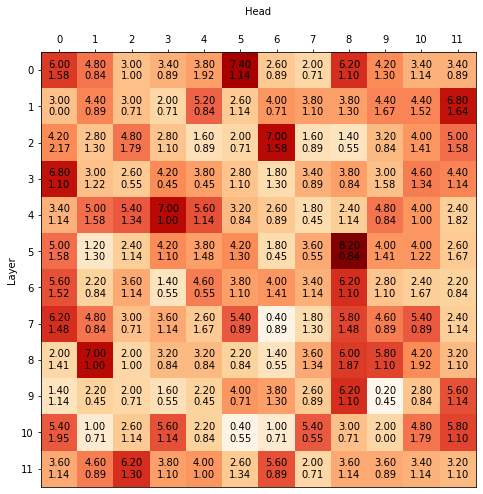

In [9]:
show_heads_heatmap(head_data, "head_heatmap_separate.pdf")

## Heads Heat map - Heads found together with MLPs setting

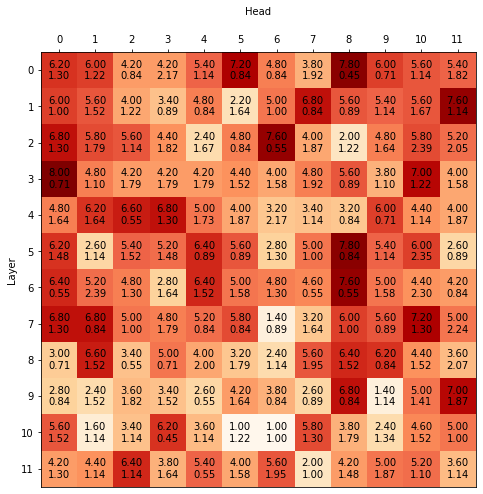

In [10]:
show_heads_heatmap(n_head_data, "head_heatmap_together.pdf")

## MLPs Heat map - MLPs found separately

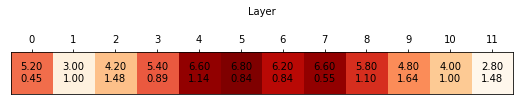

In [11]:

show_mlps_heatmap(mlp_data, "mlp_heatmap_separate.pdf")

## MLPs Heat map - MLPs found together with Heads setting

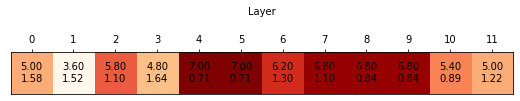

In [12]:
show_mlps_heatmap(n_mlp_data, "mlp_heatmap_together.pdf")

In [368]:
# !mkdir -p ../bad_head_mlp_masks_results
# import os
# import json
# evaluation_dir = pathlib.Path("../finetuned_models_with_head_and_mlp_mask_bad")
# output_dir = pathlib.Path("../bad_head_mlp_masks_results")
# for task_dir in evaluation_dir.iterdir():
#     for seed in task_dir.iterdir():
#         with (seed / "config.json").open() as f:
#             config = json.load(f)
#             pruned_heads = config["pruned_heads"]
#             pruned_mlps = config["pruned_heads"]
#             head_mask = np.ones((12, 12))
#             mlp_mask = np.ones(12)
#             for layer, heads in pruned_heads.items():
#                 for head in heads:
#                     head_mask[int(layer)][head] = 0
#             for layer in pruned_mlps:
#                 mlp_mask[int(layer)] = 0
#             mask_dir = output_dir / task_dir.stem / seed.stem
#             os.makedirs(str(mask_dir))
#             np.save(str(mask_dir / "head_mask.npy"), head_mask)
#             np.save(str(mask_dir / "mlp_mask.npy"), mlp_mask)


# Performance analysis

In [380]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "original_without_any_mask" / "baseline" / "results.json",
    
    # "head": evaluation_dir / "original_with_mask" / "baseline" / "results.json",
    # "head_random": evaluation_dir / "original_with_mask_random" / "baseline" / "results.json",
    # "head_invert": evaluation_dir / "original_with_mask_inverted" / "baseline" / "results.json",
   
    # "mlp": evaluation_dir / "original_with_mlp_mask" / "baseline" / "results.json",
    # "mlp_random": evaluation_dir / "original_with_mlp_mask_random" / "baseline" / "results.json",
    # "mlp_invert": evaluation_dir / "original_with_mlp_mask_invert" / "baseline" / "results.json",
   
    # "head+mlp": evaluation_dir / "original_with_mlp_mask_head_mask" / "baseline" / "results.json",
    "good sub-network (pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together" / "baseline" / "results.json",
    #"bad  sub-network (pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together_bad" / "baseline" / "results.json",
    "bad sub-network (pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together_bad_exact" / "baseline" / "results.json",

    "good sub-network (retrained)": evaluation_dir / "retrain_with_mlp_mask_head_mask_together" / "baseline" / "results.json",
    "bad sub-network (retrained)": evaluation_dir / "retrain_with_mlp_mask_head_mask_together_bad" / "baseline" / "results.json",

    # "retrain_head_random": evaluation_dir / "retrain_with_random_head_mask" / "baseline" / "results.json",
    # "retrain_head_invert": evaluation_dir / "retrain_with_invert_head_mask" / "baseline" / "results.json",
}

analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))

In [381]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D



def flatten_metrics(metrics):
    flattened = {}
    flattened["CoLA"] = {
        "metric": "Matthews correlation",
        "mean": metrics['CoLA']['mcc'][0],
        "stdv": metrics['CoLA']['mcc'][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "Accuracy",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    
    flattened["MNLI"] = {
        "metric": "Accuracy",
        "mean": metrics["MNLI"]["mnli_acc"][0],
        "stdv": metrics["MNLI"]["mnli_acc"][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "Accuracy",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    flattened["MRPC"] = {
        "metric": "Accuracy",
        "mean": metrics["MRPC"]["acc"][0],
        "stdv": metrics["MRPC"]["acc"][1]
    }
    flattened["QNLI"] = {
        "metric": "Accuracy",
        "mean": metrics["QNLI"]["acc"][0],
        "stdv": metrics["QNLI"]["acc"][1]
    }
    flattened["QQP"] = {
        "metric": "Accuracy",
        "mean": metrics["QQP"]["acc"][0],
        "stdv": metrics["QQP"]["acc"][1]
    }
    flattened["RTE"] = {
        "metric": "Accuracy",
        "mean": metrics["RTE"]["acc"][0],
        "stdv": metrics["RTE"]["acc"][1]
    }
    flattened["SST-2"] = {
        "metric": "Accuracy",
        "mean": metrics["SST-2"]["acc"][0],
        "stdv": metrics["SST-2"]["acc"][1]
    }
    flattened["STS-B"] = {
        "metric": "Pearson correlation",
        "mean": metrics["STS-B"]["pearson"][0],
        "stdv": metrics["STS-B"]["pearson"][1]
    }
    flattened["WNLI"] = {
        "metric": "Accuracy",
        "mean": metrics["WNLI"]["acc"][0],
        "stdv": metrics["WNLI"]["acc"][1]
    }
    return flattened


def plot_all_task_metrics(metrics, save_path):
    all_tasks = sorted(metrics[0][1].keys())
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in metrics]
    experiment_names = [e_m[0] for e_m in experiment_metrics]
    metrics_data = [e_m[1] for e_m in experiment_metrics]
    x_pos = np.arange(len(experiment_names))
    
    fig, axs = plt.subplots(3, 3, figsize=(9,9))

    # Get a color map
    my_cmap = cm.get_cmap('prism')
    
    # Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=8)
    patterns = [ "||" , "\\\\" , "//" , "xx" , "--", "oo","", "o"]
    
    for i, task in enumerate(all_tasks):
        means = [m[task]["mean"] for m in metrics_data]
        errors = [m[task]["stdv"] for m in metrics_data]
        row = i // 3
        col = i % 3
        axs[row, col].bar(x_pos, means, yerr=errors, align='center', color=my_cmap(my_norm(range(len(x_pos)))))   
        axs[row, col].set_ylabel(metrics_data[0][task]["metric"])
        axs[row, col].set_title(f"{task}")
        axs[row, col].set_xticks([], [])
        
        bars = axs[row, col].patches
        
        for bar, hatch in zip(bars, patterns):  # loop over bars and hatches to set hatches in correct order
            bar.set_hatch(hatch)
    legend_elements = [Patch(facecolor=my_cmap(my_norm(i)), hatch=patterns[i], label=exp) for i, exp in enumerate(experiment_names)]
    legend = plt.legend(legend_elements, experiment_names, loc='bottom center', ncol=3, bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, labelspacing=1.5, handlelength=4)
    for patch in legend.get_patches():
        patch.set_height(10)
        patch.set_y(-1)
    plt.subplots_adjust(right=1.25)
    plt.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')


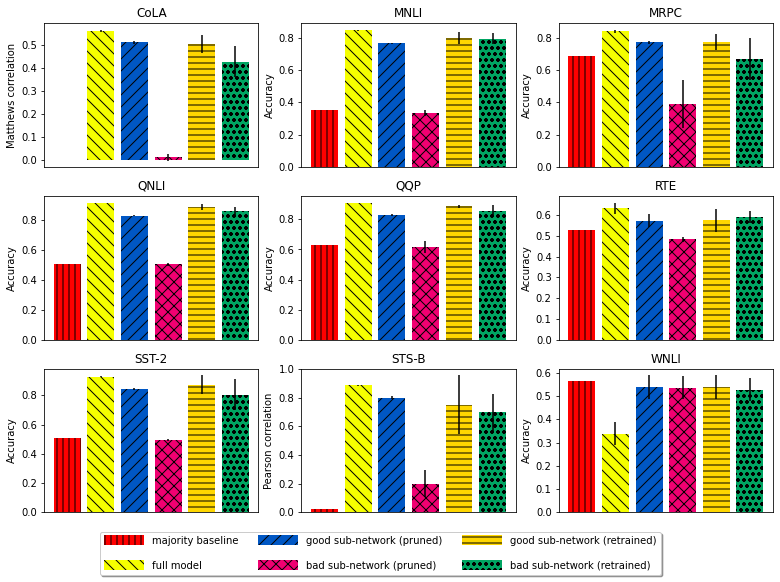

In [382]:
plot_all_task_metrics(analyzed_metrics, "tasks_evaluation.pdf")


## How would the heatmaps look if similar number of truly surviving are picked randomly, instead of actually doing the pruning experiments

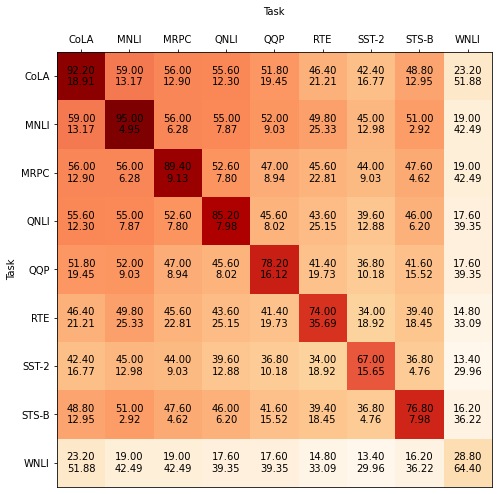

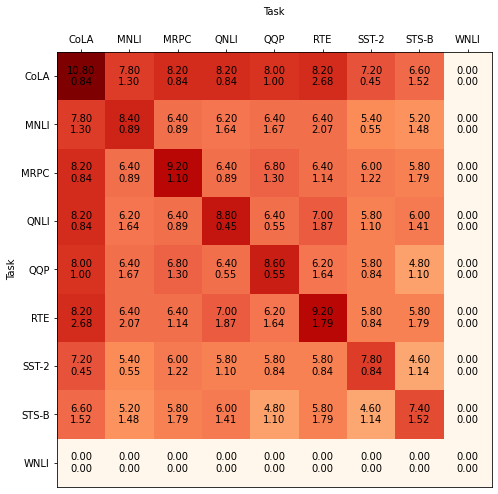

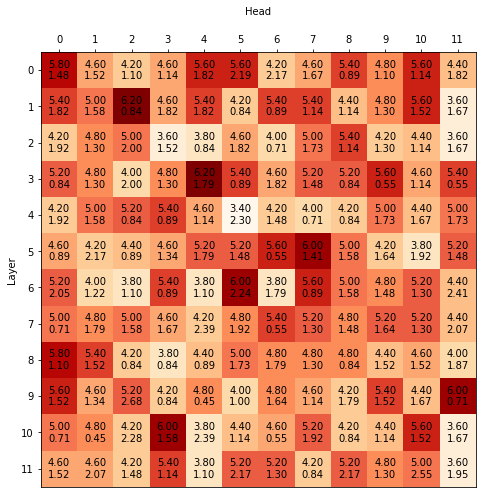

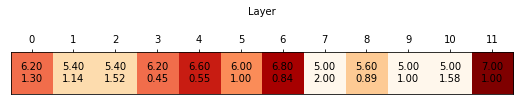

In [375]:
# Randomly generated data for each task for sanity check.
random_head_data = {}
random_mlp_data = {}
for task in head_data.keys():
    random_head_data[task] = {}
    random_mlp_data[task] = {}
    for seed in head_data[task]:
        old_head_mask = n_head_data[task][seed]["head_mask"]
        old_mlp_mask = n_mlp_data[task][seed]["mlp_mask"]
    
        heads = int(old_head_mask.sum())
        mlps = int(old_mlp_mask.sum())

        new_head_mask = np.zeros(old_head_mask.size)
        new_mlp_mask = np.zeros(old_mlp_mask.size)
        
        heads_to_one = np.random.choice(144, (heads,), replace=False)
        mlps_to_one = np.random.choice(12, (mlps,), replace=False)
        for head in heads_to_one:
            new_head_mask[head] = 1
        for mlp in mlps_to_one:
            new_mlp_mask[mlp] = 1
        
        new_head_mask = new_head_mask.reshape(old_head_mask.shape)
        new_mlp_mask = new_mlp_mask.reshape(old_mlp_mask.shape)

        random_head_data[task][seed] = {"head_mask": new_head_mask}
        random_mlp_data[task][seed] = {"mlp_mask": new_mlp_mask}

task_overlap_attention_heads(random_head_data, None)
task_overlap_mlps(random_mlp_data, None)
show_heads_heatmap(random_head_data, None)
show_mlps_heatmap(random_mlp_data, None)